# Thresholded CNNs for Forecasting S&P500 Returns
By Padraic McAtee and Tanay Trivedi 

#### Replication of the Paper:

Ghoshal, S., & Roberts, S. J. (2018). Thresholded ConvNet Ensembles: Neural Networks for Technical Forecasting. arXiv preprint arXiv:1807.03192.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Conv1D, Activation, Dense, Flatten, ThresholdedReLU, Dropout
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.utils import to_categorical


## Loading Data

In [0]:
def loadz(fn):
  with np.load(fn) as f:
    return f['arr_0']


test = loadz('gdrive/My Drive/tcnn_data/test.npz')
test_x=test[:,1]
test_y=test[:,2]
assets=test[:,3]
dates=test[:,0]
train_x = loadz('gdrive/My Drive/tcnn_data/train_x_1.npz')
train_y = loadz('gdrive/My Drive/tcnn_data/train_y_1.npz')

train_y[train_y<0]=0
cat_y=to_categorical(train_y)
train_x = train_x.transpose([0,2,1])
train_x = np.expand_dims(train_x,axis=3)

trainLen = len(train_x)
randomIdxs = np.arange(trainLen)
np.random.shuffle(randomIdxs)

cut = int(.9*trainLen)
trainIdxs = randomIdxs[:cut]
valIdxs = randomIdxs[cut:]

val_x,val_y = train_x[valIdxs],cat_y[valIdxs] 
train_x,train_y = train_x[trainIdxs],cat_y[trainIdxs]

## 3 Day Model

Model Parameters

In [0]:
m = 3 # convolution temporal size (days)
dropout = .5

BATCH_SIZE = 10000
NUM_EPOCHS = 75

Layers

In [0]:
model = Sequential()
model.add(Conv2D(8,input_shape = (4,20,1),kernel_size = (4,m),activation="relu"))
model.add(Dropout(rate=dropout))
model.add(Flatten())
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 2,activation = 'softmax'))

Training and Optimization Parameters

Compile and Train

In [0]:
opt=keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath="/content/gdrive/My Drive/midterm_checkpoints/model1_new_10k_relu_binary.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
history = model.fit(train_x,
                    train_y,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_x, val_y),
                    verbose=False,
                    callbacks=[checkpoint],shuffle=True)

In [0]:
train_preds_3=model.predict(train_x)
test_preds_3=model.predict(test_x)
maxer=np.amax(train_preds_3,axis=1)

train_preds_3=np.concatenate((train_preds_3,(maxer.reshape((-1,1)))),axis=1)
thresh=np.linspace(0.5,0.6,9)
x=thresh
train_y = loadz('gdrive/My Drive/tcnn_data/train_y_1.npz')
train_y[train_y<0]=0
train_preds_3=np.concatenate((train_preds_3,train_y[trainIdxs].reshape(-1,1)),axis=1)
outs_3=[]
for i in thresh:
  pred_i=train_preds_3[train_preds_3[:,2]>=i]
  pred_class=1-np.argmax(pred_i[:,:2],axis=1)
  outs_3.append(np.array([i,len(pred_class[pred_class==pred_i[:,3]])/float(len(pred_class)),len(pred_class)/float(len(train_preds_3))]))
newss=np.concatenate((outs_3[:,1],abs((0.1-outs_3[:,2]).reshape(-1,1))),axis=1)
closest=newss[newss[:,2].argsort()]
cross_point=closest[0,0]
import matplotlib.pyplot as plt
outs_3=np.array(outs_3)


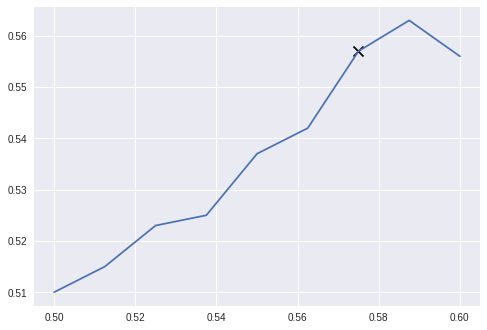

In [116]:
plt.scatter(outs_3[outs_3[:,1]==cross_point,0],cross_point,s=100,marker="x",c="black")
plt.plot(x,outs_3[:,1])

# 2 day Model

In [0]:
m = 2 # convolution temporal size (days)
dropout = .5

BATCH_SIZE = 10000
NUM_EPOCHS = 75

Layers

In [0]:
model = Sequential()
model.add(Conv2D(32,input_shape = (4,20,1),kernel_size = (4,m),activation="relu"))
model.add(Dropout(rate=dropout))
model.add(Flatten())
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 2,activation = 'softmax'))

Training and Optimization Parameters

Compile and Train

In [0]:
opt=keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath="/content/gdrive/My Drive/midterm_checkpoints/model1_new_10k_relu_binary_2day.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
history = model.fit(train_x,
                    train_y,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_x, val_y),
                    verbose=False,
                    callbacks=[checkpoint],shuffle=True)

In [0]:
train_preds_2=model.predict(train_x)
test_preds_2=model.predict(test_x)
maxer=np.amax(train_preds_2,axis=1)

train_preds_2=np.concatenate((train_preds_2,(maxer.reshape((-1,1)))),axis=1)
train_y = loadz('gdrive/My Drive/tcnn_data/train_y_1.npz')
train_y[train_y<0]=0
train_preds_2=np.concatenate((train_preds_2,train_y[trainIdxs].reshape(-1,1)),axis=1)
outs_2=[]
for i in thresh:
  pred_i=train_preds_2[train_preds_2[:,2]>=i]
  pred_class=np.argmax(pred_i[:,:2],axis=1)
  outs_2.append(np.array([i,len(pred_class[pred_class==pred_i[:,3]])/float(len(pred_class)),len(pred_class)/float(len(train_preds_2))]))
newss=np.concatenate((outs_2[:,1],abs((0.1-outs_2[:,2]).reshape(-1,1))),axis=1)
closest=newss[newss[:,2].argsort()]
cross_point_2=closest[0,0]

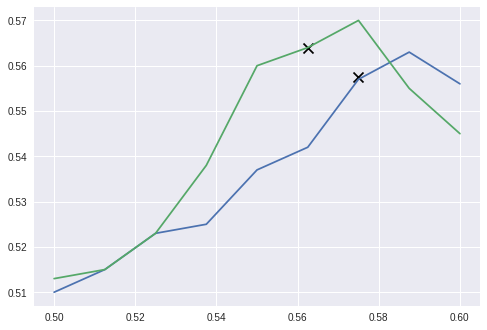

In [118]:
plt.scatter(outs_3[outs_3[:,1]==cross_point,0],cross_point,s=100,marker="x",c="black")
plt.scatter(outs_2[outs_2[:,1]==cross_point_2,0],cross_point_2,s=100,marker="x",c="black")
plt.plot(x,outs_3,x,outs_2)

# 1 day Model

In [0]:
m = 1 # convolution temporal size (days)
dropout = .5

BATCH_SIZE = 10000
NUM_EPOCHS = 75

Layers

In [0]:
model = Sequential()
model.add(Conv2D(8,input_shape = (4,20,1),kernel_size = (4,m),activation="relu"))
model.add(Dropout(rate=dropout))
model.add(Flatten())
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 64,activation = 'relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units = 2,activation = 'softmax'))

In [0]:
opt=keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath="/content/gdrive/My Drive/midterm_checkpoints/model1_new_10k_relu_binary_1day.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
history = model.fit(train_x,
                    train_y,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_x, val_y),
                    verbose=False,
                    callbacks=[checkpoint],shuffle=True)

In [0]:
test_preds_1=model.predict(test_x)
train_preds_1=model.predict(train_x)
maxer=np.amax(train_preds_1,axis=1)

train_preds_1=np.concatenate((train_preds_1,(maxer.reshape((-1,1)))),axis=1)
train_y = loadz('gdrive/My Drive/tcnn_data/train_y_1.npz')
train_y[train_y<0]=0
train_preds_1=np.concatenate((train_preds_1,train_y[trainIdxs].reshape(-1,1)),axis=1)
outs_1=[]
for i in thresh:
  pred_i=train_preds_1[train_preds_1[:,2]>=i]
  pred_class=np.argmax(pred_i[:,:2],axis=1)
  try:
    outs_1.append(np.array([i,len(pred_class[pred_class==pred_i[:,3]])/float(len(pred_class)),len(pred_class)/float(len(train_preds_1))]))
  except:
    break
newss=np.concatenate((outs_1[:,1],abs((0.1-outs_1[:,2]).reshape(-1,1))),axis=1)
closest=newss[newss[:,2].argsort()]
cross_point_1=closest[0,0]
import matplotlib.pyplot as plt

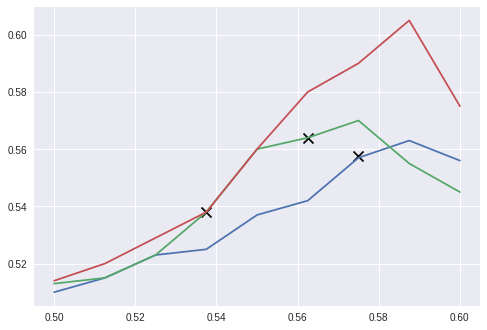

In [120]:
plt.scatter(outs_3[outs_3[:,1]==cross_point,0],cross_point,s=100,marker="x",c="black")
plt.scatter(outs_2[outs_2[:,1]==cross_point_2,0],cross_point_2,s=100,marker="x",c="black")
plt.scatter(outs_1[outs_1[:,1]==cross_point_1,0],cross_point_1,s=100,marker="x",c="black")
plt.plot(x,outs_3,x,outs_2,x,outs_1)

# Ensemble

In [0]:
ensemble_preds=[]
for i in range(len(train_preds_1)):
  ensemble_preds.append(np.mean((train_preds_1[i,:2],train_preds_2[i,:2],train_preds_3[i,:2]),axis=0))
ensemble_preds=np.array(ensemble_preds)

In [0]:
maxer=np.amax(ensemble_preds,axis=1)
ensemble_preds=np.concatenate((ensemble_preds,(maxer.reshape((-1,1)))),axis=1)
train_y = loadz('gdrive/My Drive/tcnn_data/train_y_1.npz')
train_y[train_y<0]=0
ensemble_preds=np.concatenate((ensemble_preds,train_y[trainIdxs].reshape(-1,1)),axis=1)

In [0]:
outs_ensemble=[]
for i in thresh:
  pred_i=ensemble_preds[ensemble_preds[:,2]>=i]
  pred_class=np.argmax(pred_i[:,:2],axis=1)
  try:
    outs_ensemble.append(np.array([i,len(pred_class[pred_class==pred_i[:,3]])/float(len(pred_class)),len(pred_class)/float(len(ensemble_preds))]))
  except:
    break

In [0]:
newss=np.concatenate((outs_ensemble[:,1],abs((0.1-outs_ensemble[:,2]).reshape(-1,1))),axis=1)
closest=newss[newss[:,2].argsort()]
cross_point_ensemble=closest[0,0]

# Figure 6 in the Original Paper

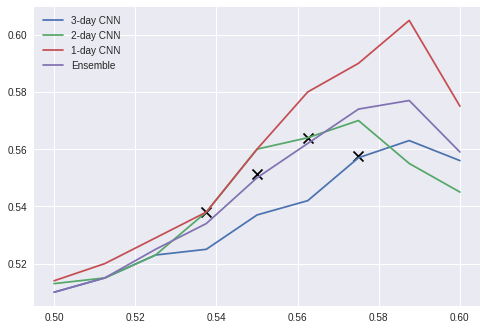

In [123]:
plt.plot(x,outs_3,label="3-day CNN")
plt.plot(x,outs_2,label="2-day CNN")
plt.plot(x,outs_1,label="1-day CNN")
plt.plot(x,outs_ensemble,label="Ensemble")

plt.scatter(outs_3[outs_3[:,1]==cross_point,0],cross_point,s=100,marker="x",c="black")
plt.scatter(outs_2[outs_2[:,1]==cross_point_2,0],cross_point_2,s=100,marker="x",c="black")
plt.scatter(outs_1[outs_1[:,1]==cross_point_1,0],cross_point_3,s=100,marker="x",c="black")
plt.scatter(outs_ensemble[outs_ensemble[:,1]==cross_point_ensemble,0],cross_point_ensemble,s=100,marker="x",c="black")

plt.legend()

# Cumulative Return

In [0]:
import matplotlib.pyplot as plt

In [0]:
ref={"1-day":test_preds_1,"2-day":test_preds_2,"3-day":test_preds_3,"ensemble":ensemble_preds}

returns={}
for i in ref.keys():
  #concat date and predictions together
  preds=ref[i]
  preds=np.concatenate((dates,test_y,preds),axis=1)
  #select predictions within threshold
  maxer=np.amax(preds[:,-2:],axis=1)
  preds=np.concatenate((preds,(maxer.reshape((-1,1)))),axis=1)
  if i== "1-day":
    preds=preds[preds[:,-1]>=cross_point_1]
  elif i=="2-day":
    preds=preds[preds[:,-1]>=cross_point_2]
  elif i=="3-day":
    preds=preds[preds[:,-1]>=cross_point]
  else:
    preds=preds[preds[:,-1]>=cross_point_ensemble]
  pred_class=np.argmax(preds[:,-3:-1],axis=1)
  #add a dictionary to returns (key it with ) with keys dates and values list appending returns*prediction sign
  un_orderd=preds[:,1]*pred_class
  unique_dates=np.unique(preds[:,0])
  rets = {k: [] for k in list(unique_dates)}
  un_ordered=np.concatenate((preds[:,0],un_ordered),axis=1)
  for j in range(len(un_ordered)):
    rets[un_ordered[j,0]].append(un_ordered[j,1])
  for j in list(rets.keys()):
    rets[j]=np.mean(np.array(rets[j]))
  returns[i]= pd.Series(list(rets.values()),index=pd.MultiIndex.from_tuples(rets.keys()))

# Figure 8 in the Original Paper

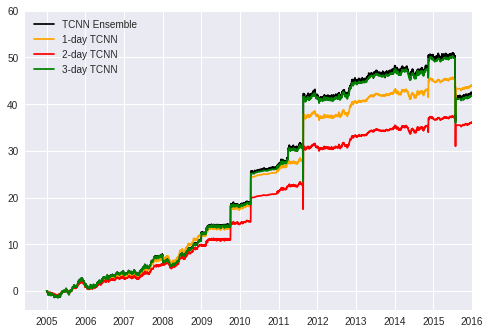

In [104]:
fig, ax = plt.subplots()
ax.plot(returns["ensemble"],c="black",label="TCNN Ensemble")
ax.plot(returns["1-day"],c="orange",label="1-day TCNN")
ax.plot(returns["2-day"],c="red",label="2-day TCNN")
ax.plot(returns["3-day"],c="green",label="3-day TCNN")

ax.set_ylim(top=60)
ax.set_xlim(right=11*252)
ax.xaxis.set_major_locator(plt.MultipleLocator(252))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
ax.legend()